# Ecoinvent efficiencies simulations - Consequential database

We want to change the "technosphere" and "biosphere" exchanges of an activity by scaling them down by a percentage (e.g. 10%) while keeping the "Production" exchange the same. This means that while, for example, an activity originally required 10 kg of technosphere input A to produce 1 kg of production output B, then we need a function that creates a copy of this activity that only needs 9 kg of A to produce 1 kg of B. This will simulate an **improvement in efficiency** for the activity that might be due to e.g. **technology upscaling** or **learning effects** and is hypothesized to be non-linear.

In this example, we use the **ecoinvent consequential** database for the simulations. 

First, we import the required Python libraries. 

In [1]:
# Data manipulation
import random
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

Import the LCA software, find the correct project, and define the **consequential** database. 

In [2]:
import brightway2 as bw

In [3]:
bw.projects.set_current('non-linearity')

In [4]:
mydb = bw.Database('ecoinvent 3.6 conseq')

## Part 1 - Changing the efficiency of coal power plants
### Where we investigate the effect of progressively increasing the efficiency of the inputs of specific activities. 

Here we want to modify the efficiency of coal power plants so we collect their codes. 

In [5]:
looking_for = ["electricity", "production", "coal"]
forbidden = ["aluminium", "supercritical", "mine"]
coal_power_plants = [a.key for a in bw.Database("ecoinvent 3.6 conseq")
                     if all(x in a["name"] for x in looking_for)
                    and not any(x in a["name"] for x in forbidden)
                    and a["reference product"] == "electricity, high voltage"]

We want to examine the effect of efficiency change of coal power plants on a number of activities.
We search the database for 10 random activities, but exclude waste and treatment activities.

In [6]:
m_act_0 = [act for act in mydb if 
            ('market activity' in act['activity type'] and 
               act['production amount'] > 0 and 
               'waste' not in act['name'])]             
random_acts_0 =  random.sample(m_act_0,10) 

In [7]:
# Extract lists of codes, names, and FUs for future use
l_names_0 = [act['name'] for act in random_acts_0]
l_codes_0 = [act['code'] for act in random_acts_0]  

# Save a list for future use
pd.DataFrame(l_codes_0).to_csv('sample_codes_conseq_part1.csv', index=False, header = ['samplecodes'], sep = ';')
pd.DataFrame(l_names_0).to_csv('sample_names_conseq_part1.csv', index=False, header = ['samplenames'], sep = ';')

In [6]:
# If a list has already been created, upload it with this code. 
mysample_0 = pd.read_csv('sample_codes_conseq_part1.csv')['samplecodes'].values.tolist()  # this to get it back
random_acts_0 = [mydb.get(code) for code in mysample_0]

We then create 10 functional units from the 10 activities. 

In [9]:
FU0 = [{act:1} for act in random_acts_0]
FU0

[{'market for transport, freight, lorry with refrigeration machine, 3.5-7.5 ton, EURO3, carbon dioxide, liquid refr(...)_11' (ton kilometer, GLO, None): 1},
 {'market for diborane' (kilogram, GLO, None): 1},
 {'market for potassium nitrate, industrial grade' (kilogram, GLO, None): 1},
 {'market for intermodal shipping container, 40-foot, high-cube' (unit, GLO, None): 1},
 {'market for land use change, pasture, man made' (hectare, BR-BA, None): 1},
 {'market for land use change, perennial crop' (hectare, CN, None): 1},
 {'market for electricity, high voltage' (kilowatt hour, CI, None): 1},
 {'market for jute plant, harvested' (kilogram, GLO, None): 1},
 {'market for electricity, medium voltage' (kilowatt hour, GR, None): 1},
 {'market for land tenure, arable land, measured as carbon net primary productivity, pasture, man made' (kilogram, BR-MA, None): 1}]

We then iterate through the functional units, and progressively increase the efficiency of the coal power plants where they are inputs to the 10 functional units. 

In [10]:
l_res_0 = []

# 'x' will represent our efficiency increase factor.
# Here we start at 1 (meaning unmodified) and go down to .2, representing a efficiency increase of 400%.

for x in np.arange(1.0, .1, -.1):
    
    # We build the technology matrix.
    
    LCA = bw.LCA(FU0[0], ('IPCC 2013', 'climate change', 'GWP 100a'))
    LCA.lci()
    LCA.lcia()
    
    
    # We get the row numbers of the power plants on the technology matrix
    coal_pp_col = [LCA.activity_dict[a] for a in coal_power_plants]
    
     # We select the columns that correspond to the power plants in the tech matrix
     # And we decrease all the values row-wise by an increment of 0.1, except for the values in the diagonal 
     # (which represent the electricity output)
    
    LCA.technosphere_matrix[
        np.ix_([c for c in range(0, LCA.technosphere_matrix.shape[0]) if c not in coal_pp_col],
               coal_pp_col)] *= x
    
    # Then we iterate through our FUs
    
    for j, fu in enumerate(FU0):
        LCA.redo_lci(fu)
        LCA.lcia()
        l_res_0.append(((1/x-1)*100, list(fu.keys())[0]["name"], LCA.score))
        print(x)
        print(fu)
        print(LCA.score)
        print('--')

1.0
{'market for transport, freight, lorry with refrigeration machine, 3.5-7.5 ton, EURO3, carbon dioxide, liquid refr(...)_11' (ton kilometer, GLO, None): 1}
0.6340823131609135
--
1.0
{'market for diborane' (kilogram, GLO, None): 1}
39.558214373864764
--
1.0
{'market for potassium nitrate, industrial grade' (kilogram, GLO, None): 1}
0.7496921131113342
--
1.0
{'market for intermodal shipping container, 40-foot, high-cube' (unit, GLO, None): 1}
22903.67466289286
--
1.0
{'market for land use change, pasture, man made' (hectare, BR-BA, None): 1}
7318.479357226321
--
1.0
{'market for land use change, perennial crop' (hectare, CN, None): 1}
-0.49535454594482076
--
1.0
{'market for electricity, high voltage' (kilowatt hour, CI, None): 1}
0.4900532094491388
--
1.0
{'market for jute plant, harvested' (kilogram, GLO, None): 1}
0.20291502053870764
--
1.0
{'market for electricity, medium voltage' (kilowatt hour, GR, None): 1}
0.1316638896770859
--
1.0
{'market for land tenure, arable land, measur

0.30000000000000016
{'market for transport, freight, lorry with refrigeration machine, 3.5-7.5 ton, EURO3, carbon dioxide, liquid refr(...)_11' (ton kilometer, GLO, None): 1}
0.6316634843123473
--
0.30000000000000016
{'market for diborane' (kilogram, GLO, None): 1}
38.04626193700722
--
0.30000000000000016
{'market for potassium nitrate, industrial grade' (kilogram, GLO, None): 1}
0.7595500604503743
--
0.30000000000000016
{'market for intermodal shipping container, 40-foot, high-cube' (unit, GLO, None): 1}
22708.71196232494
--
0.30000000000000016
{'market for land use change, pasture, man made' (hectare, BR-BA, None): 1}
7318.439385297239
--
0.30000000000000016
{'market for land use change, perennial crop' (hectare, CN, None): 1}
-0.49535454594482076
--
0.30000000000000016
{'market for electricity, high voltage' (kilowatt hour, CI, None): 1}
0.4898835412383683
--
0.30000000000000016
{'market for jute plant, harvested' (kilogram, GLO, None): 1}
0.20223315138517872
--
0.30000000000000016


In [12]:
#Create a pandas dataframe showing the results
res = pd.DataFrame(l_res_0, columns=['PP efficiency increase (%)', 'Name', 'GWP'])\
    .groupby(["Name", "PP efficiency increase (%)"])[["GWP"]].sum()
res

GWP
Name                                               PP efficiency increase (%)           
market for diborane                                0.000000                    39.558214
                                                   11.111111                   39.340683
                                                   25.000000                   39.123668
                                                   42.857143                   38.907166
                                                   66.666667                   38.691177
...                                                                                  ...
market for transport, freight, lorry with refri... 66.666667                    0.632695
                                                   100.000000                   0.632351
                                                   150.000000                   0.632007
                                                   233.333333                   0.631663
                                                   400.000000                   0.631321

[90 rows x 1 columns]

We then plot the results, where the LCA score of increasing efficiency is divided by the original LCA score to give a ratio value between 0 and 1.

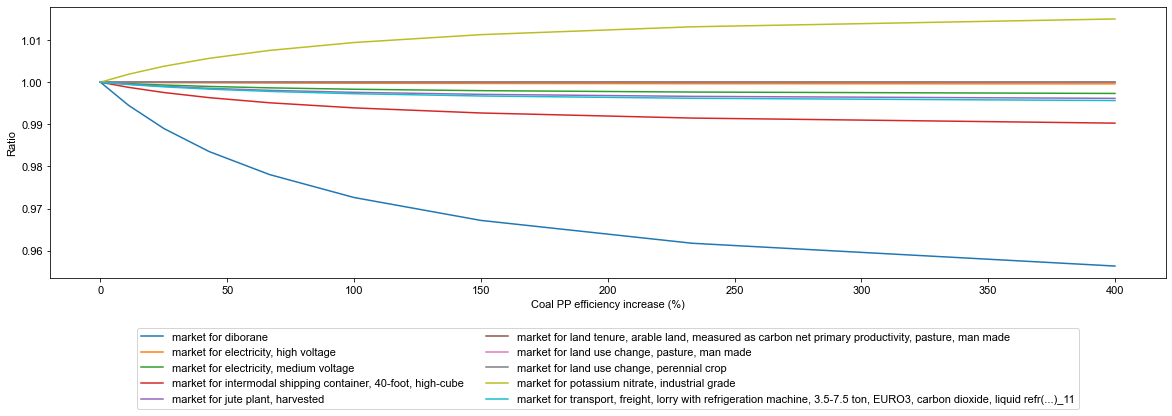

In [13]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 11}
plt.rc('font', **font)

#Plot the figure.
(res / pd.DataFrame(l_res_0, columns=['PP efficiency increase (%)', 'Name', 'GWP'])\
    .groupby(["Name"])[["GWP"]].first())["GWP"].unstack().T.plot(figsize=(20, 5))

plt.ylabel("Ratio")
plt.xlabel("Coal PP efficiency increase (%)")
lgd = plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2)
#And save the figure.
plt.savefig('conseq_part1c_2209.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Part two - Beta Distribution

### Where we study the more general effect of (randomly) increasing the efficiency of transformation activities using a beta distribution

A key question is **how** to simulate potential efficiency gains. We look only at transformation activities, not market ones - because the transformation activities are those where you can have efficiency gains while the market ones are only a mix of transformation activities (the sum of which = 1) + transport, so there is not much to upscale there. We filter the database to select only transformation activities.

We will then select some **other** activities (ideally market activities) and analyze their impact (e.g. kg CO2-eq) both with the default version of the database and with the "improvement scenario" (specific inputs of the transformation activities reduced by a percentage) and then compare the difference. This difference is the **ratio** between the two impact values expressed as a number between 0 and 1. The hypothesis is that the improved version shuold have a lower impact than the default one.

**We don't know which exchanges can be improved** and where the upscaling uncertainty is, so we model using both a **beta distribution** (seen here in Part 2) and a **uniform distribution** (seen in Part 3). 

The **beta distribution** looks like an exponential distribution but is between 0 and 1 and is appropriate to model percentages, and is modelled for a more realistic scenario. Here we assume that generally, most exchanges will be close to the maximum efficiency and the probability of being wrong is decreasing - i.e. very few exchanges will be far-off from the max efficiency value and can be improved substantially, while others can only be improved marginally. This avoids the problem of choosing a progressive efficiency gain (see Part 1 of this notebook) or of changing the efficiency using a uniform distribution (see Part 3) - both assumptions are too unrealistic.

We search the database for 50 random activities, but exclude waste and treatment activities. 

In [43]:
m_act = [act for act in mydb if 
            ('market activity' in act['activity type'] and 
               act['production amount'] > 0 and 
               'waste' not in act['name'])]              
random_acts =  random.sample(m_act,50) 

In [50]:
# Extract lists of codes, names, and FUs for future use.
l_names = [act['name'] for act in random_acts]
l_codes = [act['code'] for act in random_acts]  
FU = [{act:1} for act in random_acts] 

# Save a list for future use
pd.DataFrame(l_codes).to_csv('sample_codes_conseq.csv', index=False, header = ['samplecodes'], sep = ';')
pd.DataFrame(l_names).to_csv('sample_names_conseq.csv', index=False, header = ['samplenames'], sep = ';')

In [15]:
# If a list has already been created, upload it with this code
mysample = pd.read_csv('sample_codes_conseq.csv')['samplecodes'].values.tolist() 
random_acts = [mydb.get(code) for code in mysample]

#get list of names and codes for future use. 
l_names = [act['name'] for act in random_acts]
l_codes = [act['code'] for act in random_acts]  

We then create 50 functional units for the 50 activities. 

In [16]:
FU = [{act:1} for act in random_acts]
FU

[{'market for fuel cell, polymer electrolyte membrane, 2kW electrical, future' (unit, GLO, None): 1},
 {'market for aluminium, primary, liquid' (kilogram, GLO, None): 1},
 {'market for sulfite pulp, bleached' (kilogram, GLO, None): 1},
 {'market for palm oil, refined' (kilogram, GLO, None): 1},
 {'market for land use change, forest, intensive' (hectare, BR-MS, None): 1},
 {'market for natural gas, high pressure' (cubic meter, IE, None): 1},
 {'market for ethylene vinyl acetate copolymer' (kilogram, RER, None): 1},
 {'market for white spirit' (kilogram, GLO, None): 1},
 {'market for land tenure, arable land, measured as carbon net primary productivity, perennial crop' (kilogram, BR-AM, None): 1},
 {'market for electricity, high voltage' (kilowatt hour, UY, None): 1},
 {'market for electricity, medium voltage' (kilowatt hour, US-ASCC, None): 1},
 {'market for wood preservation, oscillating pressure method, inorganic salt, containing Cr, outdoor use, ground contact' (kilogram, GLO, None):

We then create **base** values for the sample activities. This is done before improving the efficiency of the transformation activities, so we have a value to compare to.

In [46]:
l_res_base = []

for j, fu in enumerate(FU): 
    LCA = bw.LCA(fu, ('IPCC 2013', 'climate change', 'GWP 100a'))
    LCA.lci()
    LCA.lcia()
    l_res_base.append(LCA.score) 

#Put results into a pandas Dataframe. 
pd.DataFrame({'name' : l_names, 'code' :l_codes, 'GWP' : l_res_base}).head()

,name,code,GWP
0,"market for fuel cell, polymer electrolyte memb...",6581c206ad6626be8bb5b1b12dfafba3,3472.424241
1,"market for aluminium, primary, liquid",3e1f301efb89e02ed24aa2213eff5f31,20.083028
2,"market for sulfite pulp, bleached",b8f6be7100b0eb7ce46e0c89fe068d19,2.166080
3,"market for palm oil, refined",f65722a4f1b1fbefb2a1c5ac29dc0389,4.531628
4,"market for land use change, forest, intensive",bce8e09a63d5ecfc7dc800b376f46c7d,-4493.576581


We plot the **beta distribution**, to be used when changing the efficiency of transformation activities.

(array([   5.,   21.,   67.,  179.,  335.,  621., 1041., 1654., 2443.,
        3634.]),
 array([0.13982374, 0.22584003, 0.31185633, 0.39787263, 0.48388893,
        0.56990523, 0.65592153, 0.74193783, 0.82795413, 0.91397043,
        0.99998673]),
 <BarContainer object of 10 artists>)

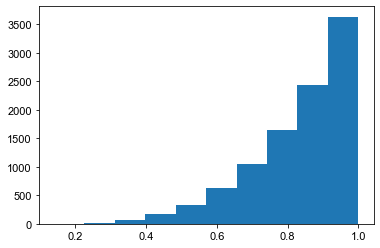

In [17]:
plt.hist(np.random.beta(5.0, 1.0, 10000))

We filter out the ordinary transforming activities. 

In [18]:
transf_act = [act for act in mydb if 'ordinary transforming activity' in act['activity type']]

In [19]:
bw.calculation_setups['multiLCA'] = {'inv': FU, 'ia': [('IPCC 2013', 'climate change', 'GWP 100a')]}
myMultiLCA = bw.MultiLCA('multiLCA')
l_res_base = myMultiLCA.results.reshape(len(FU))

In [52]:
a, b = 5., 1. # coefficients for beta distribution

l_res_sim = [] # sim = simulation

for x in range(0, 1000):   # 1000 iterations
    l_res_iter = []

    lca = bw.LCA(FU[0], ('IPCC 2013', 'climate change', 'GWP 100a'))
    lca.lci()
    lca.lcia()
    
    transf_col = [lca.activity_dict[a] for a in transf_act] # To get column index of transformation activities
    
    inds = np.where((np.isin(lca.tech_params["col"],transf_col))
                   &(lca.tech_params["col"]!=lca.tech_params["row"])
                   &(lca.tech_params["amount"]!=0))[0]
    
    vals = lca.tech_params["amount"].copy()
    
    vals[inds] *=  np.random.beta(a, b, len(vals[inds]))
    
    lca.rebuild_technosphere_matrix(vals)
    
    for fu in FU:
        lca.redo_lcia(fu)
        l_res_iter.append(lca.score)
        
    l_res_sim.append(l_res_iter)
    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [53]:
# IF YOU ARE GOING THROUGH THE SIMULATION THE FIRST TIME: 
# Put base and simulation values together in a dataframe
#res_df = pd.concat([pd.DataFrame({'Base': l_res_base}, l_names) , 
                  #  pd.DataFrame(l_res_sim, columns = l_names).T], 
                  # axis=1) # use names_list to get names instead

,Base,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
"market for fuel cell, polymer electrolyte membrane, 2kW electrical, future",3.472424e+03,2.153725e+03,1.911876e+03,1.853195e+03,1.378591e+03,1.404563e+03,1.600352e+03,1.990863e+03,2.053321e+03,1.440761e+03,2.074311e+03,2.139899e+03,1.613117e+03,1.152122e+03,1.823405e+03,1.527079e+03,2.052077e+03,1.928071e+03,1.897505e+03,1.965811e+03,1.820789e+03,2.077895e+03,1.825375e+03,2.037390e+03,1.839743e+03,...,2.190624e+03,1.792710e+03,1.914595e+03,1.999844e+03,1.562467e+03,1.499192e+03,1.915499e+03,1.562210e+03,1.983714e+03,1.982977e+03,1.950195e+03,1.968013e+03,1.704335e+03,1.786890e+03,2.129137e+03,1.515956e+03,1.743047e+03,2.009754e+03,1.748425e+03,1.820879e+03,2.035769e+03,1.922435e+03,1.731947e+03,1.809872e+03,2.067923e+03
"market for aluminium, primary, liquid",2.008303e+01,1.228133e+01,1.251475e+01,1.042291e+01,1.354607e+01,1.190641e+01,1.355886e+01,1.217701e+01,9.960286e+00,1.304642e+01,1.275311e+01,1.274687e+01,1.035671e+01,1.369274e+01,1.291634e+01,1.410740e+01,1.208036e+01,1.223019e+01,1.166066e+01,1.406983e+01,1.114635e+01,1.288469e+01,1.332125e+01,1.365131e+01,1.336010e+01,...,1.333315e+01,1.244922e+01,1.189106e+01,1.191105e+01,1.190992e+01,1.201027e+01,1.064203e+01,1.281218e+01,1.349802e+01,1.370439e+01,1.037155e+01,1.229333e+01,1.064458e+01,1.454591e+01,1.179034e+01,1.173024e+01,1.183522e+01,1.038370e+01,1.191315e+01,1.439530e+01,1.152740e+01,1.365001e+01,1.377964e+01,9.201650e+00,1.259639e+01
"market for sulfite pulp, bleached",2.166080e+00,1.368768e+00,1.796713e+00,1.722941e+00,1.534638e+00,1.665012e+00,1.868957e+00,1.407315e+00,1.895910e+00,1.672020e+00,1.793647e+00,1.768248e+00,1.742882e+00,1.819799e+00,2.049110e+00,1.764510e+00,1.777328e+00,1.828975e+00,1.784373e+00,1.785222e+00,1.809201e+00,1.440434e+00,1.615796e+00,1.653622e+00,1.620266e+00,...,1.772164e+00,1.647206e+00,1.504824e+00,1.727831e+00,1.431377e+00,2.067350e+00,1.952450e+00,1.885229e+00,1.938348e+00,1.655840e+00,1.647986e+00,1.652771e+00,1.824742e+00,1.955540e+00,1.800892e+00,1.812792e+00,1.144871e+00,1.396229e+00,1.745914e+00,1.788322e+00,1.863665e+00,1.498254e+00,1.776007e+00,1.724693e+00,1.649606e+00
"market for palm oil, refined",4.531628e+00,2.026771e+00,2.601317e+00,2.218593e+00,2.589367e+00,2.409168e+00,2.408540e+00,2.382166e+00,3.182059e+00,3.074802e+00,2.879136e+00,2.699725e+00,2.550136e+00,2.478701e+00,2.655931e+00,2.637587e+00,3.462090e+00,2.624909e+00,3.078434e+00,2.518515e+00,3.048471e+00,2.586856e+00,3.276710e+00,2.427425e+00,3.141089e+00,...,2.232638e+00,2.861505e+00,3.220664e+00,3.059743e+00,3.342718e+00,3.394295e+00,2.366576e+00,3.099532e+00,2.717761e+00,2.798793e+00,2.874372e+00,1.761178e+00,2.969351e+00,2.848040e+00,2.224495e+00,2.907063e+00,2.731869e+00,2.649109e+00,2.557505e+00,2.317481e+00,2.863334e+00,3.101112e+00,2.967698e+00,2.882748e+00,2.735442e+00
"market for land use change, forest, intensive",-4.493577e+03,-4.169782e+03,-3.983930e+03,-2.929128e+03,-3.186891e+03,-3.577157e+03,-4.336103e+03,-4.457637e+03,-3.190776e+03,-4.110002e+03,-3.768430e+03,-3.870258e+03,-4.275170e+03,-4.491981e+03,-4.460562e+03,-4.041430e+03,-3.736212e+03,-4.085177e+03,-3.751316e+03,-3.456048e+03,-3.304417e+03,-3.892194e+03,-2.949496e+03,-3.524706e+03,-4.384015e+03,...,-3.709667e+03,-4.237993e+03,-4.088390e+03,-3.923815e+03,-3.560536e+03,-4.267481e+03,-3.849059e+03,-4.375123e+03,-3.715736e+03,-4.443463e+03,-3.955419e+03,-3.826893e+03,-2.659821e+03,-3.125283e+03,-3.643223e+03,-4.452145e+03,-3.885471e+03,-3.772410e+03,-4.139718e+03,-3.422960e+03,-4.005720e+03,-3.963689e+03,-4.450707e+03,-3.037036e+03,-3.808584e+03
"market for natural gas, high pressure",1.233793e-01,8.685086e-02,9.236816e-02,9.187252e-02,9.135405e-02,7.651249e-02,9.102020e-02,9.035731e-02,8.903958e-02,8.866310e-02,9.673252e-02,8.202907e-02,8.850485e-02,8.074695e-02,9.017820e-02,8.343636e-02,9.082584e-02,8.828800e-02,8.

In [ ]:
#And save as csv file
#pd.DataFrame(res_df).to_csv('beta_dist_data_conseq.csv', index=False, sep = ';') 

In [21]:
#IF YOU HAVE ALREADY GONE THROUGH THE SIMULATION AND HAVE THE LCA DATA
#Just upload the csv file so you don't have to go through 1000 iterations again
res_df = pd.read_csv('beta_dist_data_conseq.csv', sep = ';')
res_df

,Base,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,3.472424e+03,2.153725e+03,1.911876e+03,1.853195e+03,1.378591e+03,1.404563e+03,1.600352e+03,1.990863e+03,2.053321e+03,1.440761e+03,2.074311e+03,2.139899e+03,1.613117e+03,1.152122e+03,1.823405e+03,1.527079e+03,2.052077e+03,1.928071e+03,1.897505e+03,1.965811e+03,1.820789e+03,2.077895e+03,1.825375e+03,2.037390e+03,1.839743e+03,...,2.190624e+03,1.792710e+03,1.914595e+03,1.999844e+03,1.562467e+03,1.499192e+03,1.915499e+03,1.562210e+03,1.983714e+03,1.982977e+03,1.950195e+03,1.968013e+03,1.704335e+03,1.786890e+03,2.129137e+03,1.515956e+03,1.743047e+03,2.009754e+03,1.748425e+03,1.820879e+03,2.035769e+03,1.922435e+03,1.731947e+03,1.809872e+03,2.067923e+03
1,2.008303e+01,1.228133e+01,1.251475e+01,1.042291e+01,1.354607e+01,1.190641e+01,1.355886e+01,1.217701e+01,9.960286e+00,1.304642e+01,1.275311e+01,1.274687e+01,1.035671e+01,1.369274e+01,1.291634e+01,1.410740e+01,1.208036e+01,1.223019e+01,1.166066e+01,1.406983e+01,1.114635e+01,1.288469e+01,1.332125e+01,1.365131e+01,1.336010e+01,...,1.333315e+01,1.244922e+01,1.189106e+01,1.191105e+01,1.190992e+01,1.201027e+01,1.064203e+01,1.281218e+01,1.349802e+01,1.370439e+01,1.037155e+01,1.229333e+01,1.064458e+01,1.454591e+01,1.179034e+01,1.173024e+01,1.183522e+01,1.038370e+01,1.191315e+01,1.439530e+01,1.152740e+01,1.365001e+01,1.377964e+01,9.201650e+00,1.259639e+01
2,2.166080e+00,1.368768e+00,1.796713e+00,1.722941e+00,1.534638e+00,1.665012e+00,1.868957e+00,1.407315e+00,1.895910e+00,1.672020e+00,1.793647e+00,1.768248e+00,1.742882e+00,1.819799e+00,2.049110e+00,1.764510e+00,1.777328e+00,1.828975e+00,1.784373e+00,1.785222e+00,1.809201e+00,1.440434e+00,1.615796e+00,1.653622e+00,1.620266e+00,...,1.772164e+00,1.647206e+00,1.504824e+00,1.727831e+00,1.431377e+00,2.067350e+00,1.952450e+00,1.885229e+00,1.938348e+00,1.655840e+00,1.647986e+00,1.652771e+00,1.824742e+00,1.955540e+00,1.800892e+00,1.812792e+00,1.144871e+00,1.396229e+00,1.745914e+00,1.788322e+00,1.863665e+00,1.498254e+00,1.776007e+00,1.724693e+00,1.649606e+00
3,4.531628e+00,2.026771e+00,2.601317e+00,2.218593e+00,2.589367e+00,2.409168e+00,2.408540e+00,2.382166e+00,3.182059e+00,3.074802e+00,2.879136e+00,2.699725e+00,2.550136e+00,2.478701e+00,2.655931e+00,2.637587e+00,3.462090e+00,2.624909e+00,3.078434e+00,2.518515e+00,3.048471e+00,2.586856e+00,3.276710e+00,2.427425e+00,3.141089e+00,...,2.232638e+00,2.861505e+00,3.220664e+00,3.059743e+00,3.342718e+00,3.394295e+00,2.366576e+00,3.099532e+00,2.717761e+00,2.798793e+00,2.874372e+00,1.761178e+00,2.969351e+00,2.848040e+00,2.224495e+00,2.907063e+00,2.731869e+00,2.649109e+00,2.557505e+00,2.317481e+00,2.863334e+00,3.101112e+00,2.967698e+00,2.882748e+00,2.735442e+00
4,-4.493577e+03,-4.169782e+03,-3.983930e+03,-2.929128e+03,-3.186891e+03,-3.577157e+03,-4.336103e+03,-4.457637e+03,-3.190776e+03,-4.110002e+03,-3.768430e+03,-3.870258e+03,-4.275170e+03,-4.491981e+03,-4.460562e+03,-4.041430e+03,-3.736212e+03,-4.085177e+03,-3.751316e+03,-3.456048e+03,-3.304417e+03,-3.892194e+03,-2.949496e+03,-3.524706e+03,-4.384015e+03,...,-3.709667e+03,-4.237993e+03,-4.088390e+03,-3.923815e+03,-3.560536e+03,-4.267481e+03,-3.849059e+03,-4.375123e+03,-3.715736e+03,-4.443463e+03,-3.955419e+03,-3.826893e+03,-2.659821e+03,-3.125283e+03,-3.643223e+03,-4.452145e+03,-3.885471e+03,-3.772410e+03,-4.139718e+03,-3.422960e+03,-4.005720e+03,-3.963689e+03,-4.450707e+03,-3.037036e+03,-3.808584e+03
5,1.233793e-01,8.685086e-02,9.236816e-02,9.187252e-02,9.135405e-02,7.651249e-02,9.102020e-02,9.035731e-02,8.903958e-02,8.866310e-02,9.673252e-02,8.202907e-02,8.850485e-02,8.074695e-02,9.017820e-02,8.343636e-02,9.082584e-02,8.828800e-02,8.435654e-02,8.555938e-02,8.988271e-02,8.784471e-02,9.006612e-02,9.625698e-02,7.724675e-02,...,9.528921e-02,8.952432e-02,8.628078e-02,9.227413e-02,8.216292e-02,8.555192e-02,8.699367e-02,8.856137e-02,9.009703e-02,8.149431e-02,8.013864e-02,8.312045e-02,9.300361e-0

We then calculate the ratio between the base value, and the various simulation values.

In [22]:
res_df_ratio = res_df.div(res_df.Base, axis=0).iloc[:,1:] #this excludes the first (base) column (which equals 1)
res_df_ratio

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.620237,0.550588,0.533689,0.397011,0.404491,0.460874,0.573335,0.591322,0.414915,0.597367,0.616255,0.464551,0.331792,0.525110,0.439773,0.590964,0.555252,0.546450,0.566121,0.524357,0.598399,0.525677,0.586734,0.529815,0.526213,...,0.630863,0.516271,0.551371,0.575922,0.449964,0.431742,0.551632,0.449890,0.571276,0.571064,0.561623,0.566755,0.490820,0.514594,0.613156,0.436570,0.501968,0.578776,0.503517,0.524383,0.586267,0.553629,0.498772,0.521213,0.595527
1,0.611528,0.623151,0.518991,0.674504,0.592859,0.675140,0.606333,0.495955,0.649624,0.635019,0.634709,0.515694,0.681806,0.643147,0.702454,0.601521,0.608982,0.580622,0.700583,0.555014,0.641571,0.663309,0.679744,0.665243,0.509382,...,0.663901,0.619888,0.592095,0.593090,0.593034,0.598031,0.529901,0.637961,0.672111,0.682386,0.516434,0.612125,0.530029,0.724289,0.587080,0.584087,0.589315,0.517038,0.593195,0.716789,0.573987,0.679679,0.686133,0.458180,0.627216
2,0.631910,0.829477,0.795419,0.708486,0.768675,0.862829,0.649706,0.875272,0.771911,0.828061,0.816336,0.804625,0.840135,0.945999,0.814610,0.820527,0.844371,0.823780,0.824172,0.835242,0.664996,0.745954,0.763417,0.748018,0.646622,...,0.818143,0.760455,0.694722,0.797676,0.660814,0.954420,0.901375,0.870341,0.894864,0.764441,0.760815,0.763024,0.842417,0.902801,0.831406,0.836900,0.528545,0.644588,0.806025,0.825603,0.860386,0.691689,0.819918,0.796228,0.761563
3,0.447250,0.574036,0.489580,0.571399,0.531634,0.531496,0.525675,0.702189,0.678520,0.635343,0.595752,0.562742,0.546978,0.586087,0.582040,0.763984,0.579242,0.679322,0.555764,0.672710,0.570845,0.723076,0.535663,0.693148,0.722532,...,0.492679,0.631452,0.710708,0.675197,0.737642,0.749023,0.522235,0.683978,0.599732,0.617613,0.634291,0.388641,0.655250,0.628480,0.490882,0.641505,0.602845,0.584582,0.564368,0.511401,0.631856,0.684326,0.654886,0.636140,0.603633
4,0.927943,0.886583,0.651848,0.709210,0.796060,0.964956,0.992002,0.710075,0.914639,0.838626,0.861287,0.951396,0.999645,0.992653,0.899379,0.831456,0.909115,0.834817,0.769109,0.735365,0.866168,0.656381,0.784388,0.975618,0.978815,...,0.825549,0.943122,0.909830,0.873205,0.792361,0.949685,0.856569,0.973639,0.826900,0.988848,0.880239,0.851636,0.591916,0.695500,0.810762,0.990780,0.864672,0.839512,0.921252,0.761745,0.891432,0.882079,0.990460,0.675862,0.847562
5,0.703934,0.748652,0.744635,0.740433,0.620141,0.737727,0.732354,0.721674,0.718622,0.784026,0.664853,0.717340,0.654461,0.730902,0.676259,0.736152,0.715582,0.683717,0.693466,0.728507,0.711989,0.729994,0.780172,0.626092,0.744497,...,0.772328,0.725603,0.699314,0.747890,0.665938,0.693406,0.705092,0.717798,0.730245,0.660519,0.649531,0.673699,0.753803,0.751978,0.675140,0.655626,0.788152,0.669786,0.714908,0.736261,0.785118,0.707389,0.760087,0.753984,0.697689
6,0.652237,0.797614,0.538751,0.766244,0.774412,0.671094,0.757777,0.644162,0.623105,0.724614,0.745496,0.765287,0.698659,0.835554,0.824604,0.813468,0.852245,0.802338,0.863652,0.641493,0.690157,0.709801,0.808540,0.848769,0.855184,...,0.849068,0.758504,0.766248,0.675981,0.722430,0.868155,0.532866,0.768655,0.809771,0.700868,0.884877,0.642413,0.794841,0.818188,0.767315,0.697319,0.845482,0.803710,0.883095,0.787218,0.813863,0.771086,0.788273,0.776631,0.643624
7,0.705648,0.693982,0.752887,0.686060,0.760882,0.725470,0.664506,0.746273,0.736698,0.640733,0.704173,0.763114,0.716593,0.692142,0.695527,0.592699,0.689586,0.745074,0.628580,0.746104,0.699560,0.682467,0.749319,0.643771,0.640972,...,0.701204,0.734370,0.744818,0.753591,0.688469,0.705910,0.633225,0.693223,0.655451,0.714840,0.741664,0.728557,0.607106,0.752037,0.730928,0.697788,0.707212,0.714376,0.668698,0.728492,0.662208,0.622177,0.715795,0.701937,0.704672
8,0.998716,0.998120,0.996840,0.997219,0.999122,0.998240,0.997818,0.999179,0.997677,0.997950,0.997232,0.998165,0.999212,0.997588,0.997922,0.997318,0.997287,0.998066,0.999130,0.997973,

In [56]:
#You can also save this data to a csv file. 
#pd.DataFrame(res_df_ratio).to_csv('beta_dist_ratio_conseq.csv', index=False, sep = ';')
#pd.read_csv('beta_dist_ratio_conseq.csv', sep = ';')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.620237,0.550588,0.533689,0.397011,0.404491,0.460874,0.573335,0.591322,0.414915,0.597367,0.616255,0.464551,0.331792,0.525110,0.439773,0.590964,0.555252,0.546450,0.566121,0.524357,0.598399,0.525677,0.586734,0.529815,0.526213,...,0.630863,0.516271,0.551371,0.575922,0.449964,0.431742,0.551632,0.449890,0.571276,0.571064,0.561623,0.566755,0.490820,0.514594,0.613156,0.436570,0.501968,0.578776,0.503517,0.524383,0.586267,0.553629,0.498772,0.521213,0.595527
1,0.611528,0.623151,0.518991,0.674504,0.592859,0.675140,0.606333,0.495955,0.649624,0.635019,0.634709,0.515694,0.681806,0.643147,0.702454,0.601521,0.608982,0.580622,0.700583,0.555014,0.641571,0.663309,0.679744,0.665243,0.509382,...,0.663901,0.619888,0.592095,0.593090,0.593034,0.598031,0.529901,0.637961,0.672111,0.682386,0.516434,0.612125,0.530029,0.724289,0.587080,0.584087,0.589315,0.517038,0.593195,0.716789,0.573987,0.679679,0.686133,0.458180,0.627216
2,0.631910,0.829477,0.795419,0.708486,0.768675,0.862829,0.649706,0.875272,0.771911,0.828061,0.816336,0.804625,0.840135,0.945999,0.814610,0.820527,0.844371,0.823780,0.824172,0.835242,0.664996,0.745954,0.763417,0.748018,0.646622,...,0.818143,0.760455,0.694722,0.797676,0.660814,0.954420,0.901375,0.870341,0.894864,0.764441,0.760815,0.763024,0.842417,0.902801,0.831406,0.836900,0.528545,0.644588,0.806025,0.825603,0.860386,0.691689,0.819918,0.796228,0.761563
3,0.447250,0.574036,0.489580,0.571399,0.531634,0.531496,0.525675,0.702189,0.678520,0.635343,0.595752,0.562742,0.546978,0.586087,0.582040,0.763984,0.579242,0.679322,0.555764,0.672710,0.570845,0.723076,0.535663,0.693148,0.722532,...,0.492679,0.631452,0.710708,0.675197,0.737642,0.749023,0.522235,0.683978,0.599732,0.617613,0.634291,0.388641,0.655250,0.628480,0.490882,0.641505,0.602845,0.584582,0.564368,0.511401,0.631856,0.684326,0.654886,0.636140,0.603633
4,0.927943,0.886583,0.651848,0.709210,0.796060,0.964956,0.992002,0.710075,0.914639,0.838626,0.861287,0.951396,0.999645,0.992653,0.899379,0.831456,0.909115,0.834817,0.769109,0.735365,0.866168,0.656381,0.784388,0.975618,0.978815,...,0.825549,0.943122,0.909830,0.873205,0.792361,0.949685,0.856569,0.973639,0.826900,0.988848,0.880239,0.851636,0.591916,0.695500,0.810762,0.990780,0.864672,0.839512,0.921252,0.761745,0.891432,0.882079,0.990460,0.675862,0.847562
5,0.703934,0.748652,0.744635,0.740433,0.620141,0.737727,0.732354,0.721674,0.718622,0.784026,0.664853,0.717340,0.654461,0.730902,0.676259,0.736152,0.715582,0.683717,0.693466,0.728507,0.711989,0.729994,0.780172,0.626092,0.744497,...,0.772328,0.725603,0.699314,0.747890,0.665938,0.693406,0.705092,0.717798,0.730245,0.660519,0.649531,0.673699,0.753803,0.751978,0.675140,0.655626,0.788152,0.669786,0.714908,0.736261,0.785118,0.707389,0.760087,0.753984,0.697689
6,0.652237,0.797614,0.538751,0.766244,0.774412,0.671094,0.757777,0.644162,0.623105,0.724614,0.745496,0.765287,0.698659,0.835554,0.824604,0.813468,0.852245,0.802338,0.863652,0.641493,0.690157,0.709801,0.808540,0.848769,0.855184,...,0.849068,0.758504,0.766248,0.675981,0.722430,0.868155,0.532866,0.768655,0.809771,0.700868,0.884877,0.642413,0.794841,0.818188,0.767315,0.697319,0.845482,0.803710,0.883095,0.787218,0.813863,0.771086,0.788273,0.776631,0.643624
7,0.705648,0.693982,0.752887,0.686060,0.760882,0.725470,0.664506,0.746273,0.736698,0.640733,0.704173,0.763114,0.716593,0.692142,0.695527,0.592699,0.689586,0.745074,0.628580,0.746104,0.699560,0.682467,0.749319,0.643771,0.640972,...,0.701204,0.734370,0.744818,0.753591,0.688469,0.705910,0.633225,0.693223,0.655451,0.714840,0.741664,0.728557,0.607106,0.752037,0.730928,0.697788,0.707212,0.714376,0.668698,0.728492,0.662208,0.622177,0.715795,0.701937,0.704672
8,0.998716,0.998120,0.996840,0.997219,0.999122,0.998240,0.997818,0.999179,0.997677,0.997950,0.997232,0.998165,0.999212,0.997588,0.997922,0.997318,0.997287,0.998066,0.999130,0.997973,

In [23]:
#Check to see if base ratio is 1, and if there are any NaN values. 
df_base_check = res_df.iloc[:,0].div(res_df.Base, axis=0)
print(df_base_check[df_base_check == 1.0].count(), 'out of' , res_df.shape[0] , 'equals one')
print(df_base_check.isnull().sum(), 'out of' , res_df.shape[0] , 'is NaN')


50 out of 50 equals one
0 out of 50 is NaN


We then plot the results. 

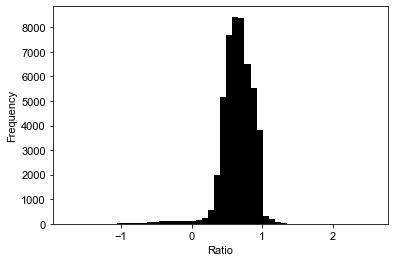

In [24]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 11}
plt.rc('font', **font)

res_df_ratio.stack().plot.hist(bins = 50, color = 'black')
plt.ylabel('Frequency')
plt.xlabel('Ratio')
#And save the figure. 
plt.savefig('conseq_beta_histogram.png')

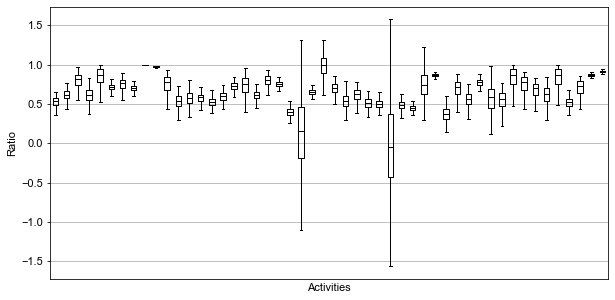

In [25]:
res_df_ratio.T.boxplot(figsize=(10,5), showfliers=False, color = 'black')
plt.xticks([])
plt.ylabel('Ratio')
plt.xlabel('Activities')
plt.savefig('conseq_beta_boxplot.png')

## Part 3 - Uniform Distribution
### Where we study the more general effect of (randomly) increasing the efficiency of transformation activities using a uniform distribution

In this second scenario, we will change the efficiency of transformation using a **uniform distribution** instead of a beta distribution. The uniform distribution means there is an equal probability of choosing all values between 0 and 1, so the selection of values is more random than in the beta distribution. 

We plot the uniform distribution, to be used when changing the efficiency of transformation activities.

(array([ 963.,  988.,  984., 1016., 1030.,  979.,  974., 1057.,  974.,
        1035.]),
 array([9.51684201e-05, 1.00075129e-01, 2.00055090e-01, 3.00035051e-01,
        4.00015011e-01, 4.99994972e-01, 5.99974933e-01, 6.99954894e-01,
        7.99934854e-01, 8.99914815e-01, 9.99894776e-01]),
 <BarContainer object of 10 artists>)

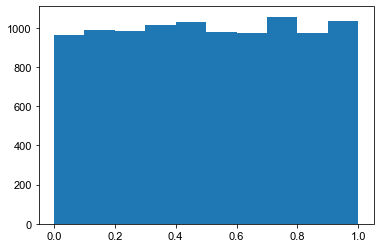

In [27]:
plt.hist(np.random.uniform(0.0, 1.0, 10000))

In [74]:
c, d = 0., 1. # coefficients for uniform distribution

l_res_sim_u = [] # sim = simulation

for x in range(0, 1000):   # 1000 iterations
    l_res_iter_u = []

    lca = bw.LCA(FU[0], ('IPCC 2013', 'climate change', 'GWP 100a'))
    lca.lci()
    lca.lcia()
    
    transf_col = [lca.activity_dict[a] for a in transf_act] # To get column index of transformation activities
    
    inds = np.where((np.isin(lca.tech_params["col"],transf_col))
                   &(lca.tech_params["col"]!=lca.tech_params["row"])
                   &(lca.tech_params["amount"]!=0))[0]
    
    vals = lca.tech_params["amount"].copy()
    
    vals[inds] *=  np.random.uniform(c, d, len(vals[inds]))
    
    lca.rebuild_technosphere_matrix(vals)
    
    for fu in FU:
        lca.redo_lcia(fu)
        l_res_iter_u.append(lca.score)
        
    l_res_sim_u.append(l_res_iter_u)
    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [75]:
# IF YOU ARE GOING THROUGH THE SIMULATION THE FIRST TIME: 
# Put base and simulation values together in a dataframe
#res_df_u = pd.concat([pd.DataFrame({'Base': l_res_base}, l_names) , 
                #    pd.DataFrame(l_res_sim_u, columns = l_names).T], 
                 #  axis=1) # use names_list to get names instead
#res_df_u

,Base,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
"market for fuel cell, polymer electrolyte membrane, 2kW electrical, future",3.472424e+03,4.006956e+02,6.510376e+02,8.904629e+02,4.433651e+02,4.067814e+02,3.825455e+02,1.019717e+02,9.406774e+02,3.225586e+02,2.725403e+02,3.179343e+02,6.185397e+02,2.811761e+02,1.595106e+02,1.763717e+02,1.951125e+02,2.984458e+02,3.891724e+02,3.184636e+02,2.946592e+02,5.683882e+02,5.102364e+02,4.106518e+02,3.081240e+02,...,5.629283e+02,5.603874e+02,6.538957e+02,4.036709e+02,6.267999e+02,5.926740e+02,3.262872e+02,4.137210e+02,3.462510e+02,1.765994e+02,5.749716e+02,6.925693e+02,2.903323e+02,2.622477e+02,5.797759e+02,1.601010e+02,3.478364e+02,3.464528e+02,4.365862e+02,7.007002e+02,8.331654e+02,1.717708e+02,7.616481e+02,2.255690e+02,9.658560e+02
"market for aluminium, primary, liquid",2.008303e+01,4.456150e+00,4.297481e+00,4.339641e+00,3.691786e+00,4.546046e+00,5.456082e+00,3.192651e+00,6.998533e+00,5.165452e+00,5.228042e+00,8.053271e+00,4.358010e+00,5.198686e+00,4.931963e+00,5.344265e+00,4.418716e+00,4.212575e+00,4.953572e+00,6.107535e+00,3.406201e+00,4.448634e+00,5.267175e+00,4.072714e+00,4.122096e+00,...,4.104044e+00,6.918123e+00,4.919364e+00,4.155514e+00,6.165941e+00,4.608120e+00,3.927936e+00,3.559354e+00,3.876742e+00,3.472843e+00,3.648361e+00,4.215316e+00,5.154916e+00,5.421367e+00,3.686223e+00,5.779456e+00,7.468709e+00,3.647566e+00,4.441590e+00,3.883284e+00,4.256985e+00,3.702069e+00,4.902100e+00,4.354977e+00,4.651612e+00
"market for sulfite pulp, bleached",2.166080e+00,1.064607e+00,3.919797e-01,9.674485e-01,1.093089e+00,1.202141e+00,6.959365e-01,3.701967e-01,1.405203e+00,1.057500e+00,8.369534e-01,7.130913e-01,7.692164e-01,2.731501e-01,7.402873e-01,6.059548e-01,6.528498e-01,2.782292e-01,1.465363e+00,1.445149e+00,6.058907e-01,9.987821e-01,1.905152e+00,4.491734e-01,1.035313e+00,...,1.007624e+00,1.049163e-01,1.370964e+00,6.298976e-01,1.449654e+00,5.349933e-01,9.822668e-01,1.281462e+00,1.065762e+00,9.123704e-01,5.125281e-01,7.925899e-01,1.412739e+00,3.800309e-01,1.314712e+00,1.298314e+00,1.430568e+00,9.627141e-01,1.307540e+00,1.490726e+00,1.035815e+00,4.004712e-01,1.742391e+00,1.150217e-01,1.146912e+00
"market for palm oil, refined",4.531628e+00,1.212555e+00,5.942653e-01,1.533545e+00,8.377603e-01,8.602892e-01,9.590932e-01,1.030961e+00,2.623837e-01,1.242580e+00,6.083484e-01,1.022461e+00,5.033248e-01,3.576756e-01,6.694527e-01,7.269013e-01,2.873609e-01,2.790080e-01,1.532017e+00,2.020404e-01,5.979665e-01,9.928840e-01,1.786910e+00,8.065803e-01,9.595316e-01,...,6.792542e-01,7.227424e-01,7.480128e-01,5.184806e-01,4.378957e-01,1.456493e+00,1.417732e+00,3.022921e-01,1.225004e+00,9.682945e-01,1.046732e+00,1.148362e+00,8.634156e-01,1.294915e+00,1.401572e+00,1.429772e+00,2.392239e-01,5.212933e-01,8.007260e-01,1.009544e+00,8.007848e-01,4.420730e-01,4.354277e-01,9.831085e-01,4.548615e-01
"market for land use change, forest, intensive",-4.493577e+03,-4.000075e+03,-3.836446e+03,-3.385561e+03,-8.171720e+02,-1.159955e+03,-4.029271e+03,-3.441160e+03,-3.472568e+03,-2.491146e+03,-3.694643e+03,-2.400094e+03,-4.365286e+03,-9.331505e+02,-3.546197e+03,-3.248378e+03,-2.621912e+03,-1.017322e+03,-4.247287e+03,-3.681953e+03,-1.334533e+03,-1.474702e+03,-3.909287e+03,-9.388924e+02,-4.173340e+03,...,-3.814091e+03,-3.982319e+03,-1.432544e+03,-4.493086e+03,-3.614906e+03,-1.970232e+03,-3.142287e+03,-1.639909e+03,-4.239563e+03,-3.951883e+03,-2.697113e+03,-1.576411e+03,-1.451933e+03,-3.034443e+03,-2.192509e+03,-4.275558e+03,-2.318514e+03,-3.330234e+03,-1.982923e+03,-3.842950e+03,-2.157333e+03,-5.310595e+02,-2.607041e+03,-4.186617e+03,-1.245933e+03
"market for natural gas, high pressure",1.233793e-01,4.087540e-02,7.158486e-02,4.485602e-02,4.781951e-02,4.968731e-02,5.552571e-02,4.811850e-02,5.194827e-02,4.023046e-02,4.667347e-02,5.068645e-02,5.896850e-02,4.268292e-02,4.421164e-02,5.629251e-02,6.080068e-02,4.705808e-02,5.

In [28]:
#And save as csv file
#pd.DataFrame(res_df_u).to_csv('uniform_dist_data_conseq.csv', index=False, sep = ';')

In [29]:
#IF YOU HAVE ALREADY GONE THROUGH THE SIMULATION AND HAVE THE LCA DATA
#Just upload the csv file so you don't have to go through 1000 iterations again
res_df_u = pd.read_csv('uniform_dist_data_conseq.csv', sep = ';')
res_df_u

,Base,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,3.472424e+03,4.006956e+02,6.510376e+02,8.904629e+02,4.433651e+02,4.067814e+02,3.825455e+02,1.019717e+02,9.406774e+02,3.225586e+02,2.725403e+02,3.179343e+02,6.185397e+02,2.811761e+02,1.595106e+02,1.763717e+02,1.951125e+02,2.984458e+02,3.891724e+02,3.184636e+02,2.946592e+02,5.683882e+02,5.102364e+02,4.106518e+02,3.081240e+02,...,5.629283e+02,5.603874e+02,6.538957e+02,4.036709e+02,6.267999e+02,5.926740e+02,3.262872e+02,4.137210e+02,3.462510e+02,1.765994e+02,5.749716e+02,6.925693e+02,2.903323e+02,2.622477e+02,5.797759e+02,1.601010e+02,3.478364e+02,3.464528e+02,4.365862e+02,7.007002e+02,8.331654e+02,1.717708e+02,7.616481e+02,2.255690e+02,9.658560e+02
1,2.008303e+01,4.456150e+00,4.297481e+00,4.339641e+00,3.691786e+00,4.546046e+00,5.456082e+00,3.192651e+00,6.998533e+00,5.165452e+00,5.228042e+00,8.053271e+00,4.358010e+00,5.198686e+00,4.931963e+00,5.344265e+00,4.418716e+00,4.212575e+00,4.953572e+00,6.107535e+00,3.406201e+00,4.448634e+00,5.267175e+00,4.072714e+00,4.122096e+00,...,4.104044e+00,6.918123e+00,4.919364e+00,4.155514e+00,6.165941e+00,4.608120e+00,3.927936e+00,3.559354e+00,3.876742e+00,3.472843e+00,3.648361e+00,4.215316e+00,5.154916e+00,5.421367e+00,3.686223e+00,5.779456e+00,7.468709e+00,3.647566e+00,4.441590e+00,3.883284e+00,4.256985e+00,3.702069e+00,4.902100e+00,4.354977e+00,4.651612e+00
2,2.166080e+00,1.064607e+00,3.919797e-01,9.674485e-01,1.093089e+00,1.202141e+00,6.959365e-01,3.701967e-01,1.405203e+00,1.057500e+00,8.369534e-01,7.130913e-01,7.692164e-01,2.731501e-01,7.402873e-01,6.059548e-01,6.528498e-01,2.782292e-01,1.465363e+00,1.445149e+00,6.058907e-01,9.987821e-01,1.905152e+00,4.491734e-01,1.035313e+00,...,1.007624e+00,1.049163e-01,1.370964e+00,6.298976e-01,1.449654e+00,5.349933e-01,9.822668e-01,1.281462e+00,1.065762e+00,9.123704e-01,5.125281e-01,7.925899e-01,1.412739e+00,3.800309e-01,1.314712e+00,1.298314e+00,1.430568e+00,9.627141e-01,1.307540e+00,1.490726e+00,1.035815e+00,4.004712e-01,1.742391e+00,1.150217e-01,1.146912e+00
3,4.531628e+00,1.212555e+00,5.942653e-01,1.533545e+00,8.377603e-01,8.602892e-01,9.590932e-01,1.030961e+00,2.623837e-01,1.242580e+00,6.083484e-01,1.022461e+00,5.033248e-01,3.576756e-01,6.694527e-01,7.269013e-01,2.873609e-01,2.790080e-01,1.532017e+00,2.020404e-01,5.979665e-01,9.928840e-01,1.786910e+00,8.065803e-01,9.595316e-01,...,6.792542e-01,7.227424e-01,7.480128e-01,5.184806e-01,4.378957e-01,1.456493e+00,1.417732e+00,3.022921e-01,1.225004e+00,9.682945e-01,1.046732e+00,1.148362e+00,8.634156e-01,1.294915e+00,1.401572e+00,1.429772e+00,2.392239e-01,5.212933e-01,8.007260e-01,1.009544e+00,8.007848e-01,4.420730e-01,4.354277e-01,9.831085e-01,4.548615e-01
4,-4.493577e+03,-4.000075e+03,-3.836446e+03,-3.385561e+03,-8.171720e+02,-1.159955e+03,-4.029271e+03,-3.441160e+03,-3.472568e+03,-2.491146e+03,-3.694643e+03,-2.400094e+03,-4.365286e+03,-9.331505e+02,-3.546197e+03,-3.248378e+03,-2.621912e+03,-1.017322e+03,-4.247287e+03,-3.681953e+03,-1.334533e+03,-1.474702e+03,-3.909287e+03,-9.388924e+02,-4.173340e+03,...,-3.814091e+03,-3.982319e+03,-1.432544e+03,-4.493086e+03,-3.614906e+03,-1.970232e+03,-3.142287e+03,-1.639909e+03,-4.239563e+03,-3.951883e+03,-2.697113e+03,-1.576411e+03,-1.451933e+03,-3.034443e+03,-2.192509e+03,-4.275558e+03,-2.318514e+03,-3.330234e+03,-1.982923e+03,-3.842950e+03,-2.157333e+03,-5.310595e+02,-2.607041e+03,-4.186617e+03,-1.245933e+03
5,1.233793e-01,4.087540e-02,7.158486e-02,4.485602e-02,4.781951e-02,4.968731e-02,5.552571e-02,4.811850e-02,5.194827e-02,4.023046e-02,4.667347e-02,5.068645e-02,5.896850e-02,4.268292e-02,4.421164e-02,5.629251e-02,6.080068e-02,4.705808e-02,5.722964e-02,4.811415e-02,6.406228e-02,4.071097e-02,4.799047e-02,4.965091e-02,4.151887e-02,...,5.671713e-02,3.937138e-02,5.307666e-02,4.712406e-02,5.860686e-02,4.088458e-02,4.394966e-02,5.204566e-02,6.207904e-02,6.216831e-02,5.873559e-02,4.378635e-02,4.727467e-0

We then calculate the ratio between the base value, and the various simulation values.

In [30]:
res_df_u_ratio = res_df_u.div(res_df_u.Base, axis=0).iloc[:,1:]
res_df_u_ratio

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.115394,0.187488,0.256438,0.127682,0.117146,0.110167,0.029366,0.270899,0.092891,0.078487,0.091560,0.178129,0.080974,0.045936,0.050792,0.056189,0.085947,0.112075,0.091712,0.084857,0.163686,0.146940,0.118261,0.088735,0.044109,...,0.162114,0.161382,0.188311,0.116250,0.180508,0.170680,0.093965,0.119145,0.099714,0.050858,0.165582,0.199448,0.083611,0.075523,0.166966,0.046106,0.100171,0.099773,0.125730,0.201790,0.239938,0.049467,0.219342,0.064960,0.278150
1,0.221886,0.213986,0.216085,0.183826,0.226363,0.271676,0.158973,0.348480,0.257205,0.260321,0.400999,0.217000,0.258860,0.245579,0.266109,0.220022,0.209758,0.246655,0.304114,0.169606,0.221512,0.262270,0.202794,0.205253,0.232546,...,0.204354,0.344476,0.244951,0.206917,0.307022,0.229453,0.195585,0.177232,0.193036,0.172924,0.181664,0.209894,0.256680,0.269948,0.183549,0.287778,0.371892,0.181624,0.221161,0.193361,0.211969,0.184338,0.244092,0.216849,0.231619
2,0.491490,0.180963,0.446636,0.504639,0.554984,0.321288,0.170906,0.648731,0.488209,0.386391,0.329208,0.355119,0.126103,0.341764,0.279747,0.301397,0.128448,0.676504,0.667173,0.279718,0.461101,0.879539,0.207367,0.477966,0.665865,...,0.465183,0.048436,0.632924,0.290801,0.669252,0.246987,0.453477,0.591604,0.492023,0.421208,0.236616,0.365910,0.652210,0.175446,0.606955,0.599384,0.660441,0.444450,0.603643,0.688214,0.478198,0.184883,0.804398,0.053101,0.529488
3,0.267576,0.131137,0.338409,0.184870,0.189841,0.211644,0.227503,0.057901,0.274202,0.134245,0.225628,0.111069,0.078929,0.147729,0.160406,0.063412,0.061569,0.338072,0.044585,0.131954,0.219101,0.394320,0.177989,0.211741,0.246157,...,0.149892,0.159488,0.165065,0.114414,0.096631,0.321406,0.312853,0.066707,0.270323,0.213675,0.230984,0.253411,0.190531,0.285751,0.309287,0.315509,0.052790,0.115034,0.176697,0.222777,0.176710,0.097553,0.096086,0.216944,0.100375
4,0.890176,0.853762,0.753422,0.181853,0.258136,0.896673,0.765795,0.772785,0.554379,0.822206,0.534117,0.971450,0.207663,0.789170,0.722894,0.583480,0.226395,0.945191,0.819381,0.296987,0.328180,0.869972,0.208941,0.928735,0.538654,...,0.848787,0.886225,0.318798,0.999891,0.804461,0.438455,0.699284,0.364945,0.943472,0.879451,0.600215,0.350814,0.323113,0.675285,0.487921,0.951482,0.515962,0.741110,0.441279,0.855210,0.480093,0.118182,0.580171,0.931689,0.277270
5,0.331299,0.580202,0.363562,0.387581,0.402720,0.450041,0.390005,0.421045,0.326071,0.378293,0.410818,0.477945,0.345949,0.358339,0.456256,0.492795,0.381410,0.463851,0.389970,0.519231,0.329966,0.388967,0.402425,0.336514,0.361663,...,0.459697,0.319109,0.430191,0.381945,0.475014,0.331373,0.356216,0.421835,0.503156,0.503880,0.476057,0.354892,0.383165,0.414747,0.383425,0.483158,0.354381,0.373477,0.448106,0.509357,0.440019,0.377802,0.424863,0.514429,0.367680
6,0.220151,0.686750,0.364222,0.629040,0.254296,0.151284,0.401232,0.362891,0.550327,0.275033,0.552139,0.236174,0.357495,0.611480,0.621807,0.103967,0.272626,0.438582,0.250420,0.403449,0.561797,0.359540,0.658673,0.292786,0.259562,...,0.160759,0.371413,0.270054,0.281952,0.198454,0.502184,0.606844,0.475841,0.406374,0.525358,0.357658,0.506778,0.261864,0.642216,0.282030,0.280967,0.580574,0.261162,0.360541,0.171987,0.281898,0.109293,0.434250,0.597443,0.271562
7,0.365652,0.349639,0.304217,0.328889,0.473922,0.321903,0.343002,0.443490,0.390785,0.308344,0.280785,0.368477,0.340206,0.428604,0.340167,0.380053,0.441498,0.332452,0.435979,0.386061,0.356955,0.482268,0.297362,0.357558,0.444155,...,0.384316,0.260042,0.275305,0.336038,0.303683,0.327299,0.324224,0.374625,0.313646,0.366887,0.393085,0.343580,0.340119,0.387691,0.359266,0.495439,0.348057,0.328655,0.294988,0.466631,0.423369,0.267985,0.435831,0.480703,0.328766
8,0.996241,0.993892,0.996076,0.998155,0.994873,0.997865,0.994956,0.998545,0.997827,0.993570,0.993571,0.995787,0.998829,0.995508,0.997335,0.997369,0.993967,0.995815,0.996847,0.995346,

In [78]:
#Can save this output as well. 
#pd.DataFrame(res_df_u_ratio).to_csv('uniform_dist_ratio.csv', index=False, sep = ';')
#And upload it
#pd.read_csv('uniform_dist_ratio.csv', sep = ';')

We then plot. 

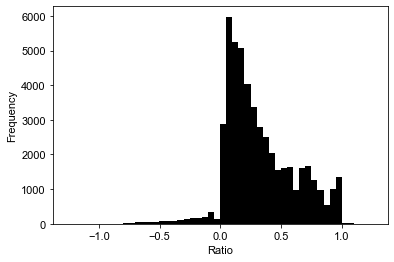

In [31]:
res_df_u_ratio.stack().plot.hist(bins = 50, color = 'black')
plt.ylabel('Frequency')
plt.xlabel('Ratio')
#And save figure. 
plt.savefig('conseq_uniform_histogram.png')

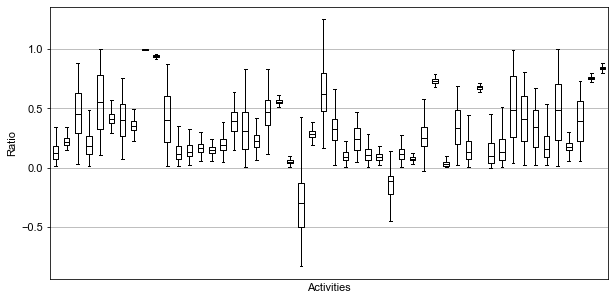

In [32]:
res_df_u_ratio.T.boxplot(figsize=(10,5), showfliers=False, color = 'black')
plt.xticks([])
plt.ylabel('Ratio')
plt.xlabel('Activities')
plt.savefig('conseq_uniform_boxplot.png')